In [217]:
import numpy as np
import sympy
from matplotlib import pyplot as plt
import scipy
import scipy.optimize
import scipy.integrate
from scipy.stats.mstats import gmean

## Assumptions:

1. Constant liquid hold up on each plate 
2. Constant liquid flow in each of the three sections of the column
3. Constant vapour flow in the column
4. No vapour holdup in the column
5. Constant hold up in reboiler and condenser
6. Constant relative volatility

In [218]:
def vol(xi):
    
    x= np.asarray([ 0.019, 0.0721, 0.0966, 0.1238, 0.1661, 0.2337, 0.2608, 
              0.3273, 0.3965, 0.5079, 0.5198, 0.5732, 0.6763, 0.7472, 0.8943])
    y = np.asarray([ 0.170, 0.3891, 0.4375, 0.4704, 0.5089, 0.5445, 0.5580, 
              0.5826, 0.6122, 0.6564, 0.6599, 0.6841, 0.7385, 0.7815, 0.8943])
    
    αi = (y*(1-x))/(x*(1-y))
#     α = np.average(αi)
    α = gmean(αi)
    yi = (α*xi)/(1+(α-1)*xi)
    
    return yi

In [219]:
def liquid_enthalpy(xi):
    HL = -6795.76505219*xi + 6811.32037477
    return HL

def vapour_enthalpy(yi):
    HV = -9272.62083371 *yi + 48236.06928559
    return HV

In [220]:
def cond_duty(V,xi,yi):
    Hl = liquid_enthalpy(xi)
    Hv = vapour_enthalpy(yi)
    
    λ =  Hv - Hl
    
    Qcond = -V*λ
    
    return Qcond

In [221]:
def rebl_duty(V,xi,yi):
    Hl = liquid_enthalpy(xi)
    Hv = vapour_enthalpy(yi)
    
    λ =  Hv - Hl
    
    Qrebl = V*λ
    
    return Qrebl

In [222]:
def mod(t,var):
    
    x0,x1,x2 = var
    
    L0 = R_r*D
    V = L0 + D 
    L1 = L0 + F
    B = F-D

    y1 = vol(x1)
    y2 = vol(x2)
    
    # Condenser composition
    dx0dt = (1/m_cond)*(y1*V - (L0+D)*x0)
    
    # Feed plate 3
    dx1dt = (1/m_tray)*(V*(y2-y1) + L0*x0 - L1*x1 + xF*F)

    # Reboiler composition
    dx2dt = (1/m_rebl)*(- V*y2 + L1*x1 - x2*B)
    
    return [dx0dt, dx1dt, dx2dt]

In [243]:
def mod_e(t,var):
    
    x0,x1,x2,h0,h1,h2 = var
    
    L0 = R_r*D
    V = L0 + D 
    L1 = L0 + F
    B = F - D

    y0 = vol(x1)
    y1 = vol(x1)
    y2 = vol(x2)
    
    H1 = vapour_enthalpy(y1)
    H2 = vapour_enthalpy(y2)
    hf = liquid_enthalpy(xF)
    
    # Condenser composition
    dx0dt = (1/m_cond)*(y1*V - (L0+D)*x0)
    dh0dt = (1/m_cond)*(H1*V - (L0+D)*h0 + cond_duty(V,x0,x0))
    
    # Feed plate 3
    dx1dt = (1/m_tray)*(V*(y2-y1) + L0*x0 - L1*x1 + xF*F )
    dh1dt = (1/m_tray)*(V*(H2-H1) + L0*h0 - L1*H1 + hf*F)

    # Reboiler composition
    dx2dt = (1/m_rebl)*(- V*y2 + L1*x1 - x2*B)
    dh2dt = (1/m_rebl)*(- V*H2 + L1*h1 - h2*B + rebl_duty(V,x2,y2))
    
    return [dx0dt, dx1dt, dx2dt, dh0dt, dh1dt, dh2dt]

## Inputs to calculate intial state

### Input variables

1. $F_3$ - Feed flow rate on plate 3
2. $F_7$ - Feed flow rate on plate 7
3. $x_F$ - Feed liquid composition
4. $Rr$ - Reflux ratio
5. $D_F$ - Distillate to feed ratio

### Parameters

1. $\alpha$ - Relative volatility
2. $m_{tray}$ - holdup on each tray
2. $m_{cond}$ - holdup in the total condenser
2. $m_{rebl}$ - holdup in the partial reboiler

In [244]:
init = [0.1, 0.1, 0.1, liquid_enthalpy(0.1), liquid_enthalpy(0.1), liquid_enthalpy(0.1) ]
# init = [0.1, 0.1, 0.1]
# init = [0.4239734327966502, 0.1946105255501814, 0.07625329798664819]
# init = [0.4239734327966502, 0.1946105255501814, 0.07625329798664819,
#         liquid_enthalpy(0.4239734327966502), liquid_enthalpy(0.1946105255501814), liquid_enthalpy(0.07625329798664819) ]
print(liquid_enthalpy(0.1))
F = 1 # Feed on plate 3
D = 0.5
xF = 0.25 # mole fraction in feed
R_r = 20 # reflux ratio

m_cond = 0.15 # holdup in condenser
m_tray = 0.2 # holdup on each tray
m_rebl = 0.45 # holdup in reboiler
mt = 0.15+0.2+0.45

6131.743869551


In [240]:
tspan = (0, 15)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mod_e, tspan, init, t_eval=t)

In [241]:
# x0,x1,x2 = initial_run.y
x0,x1,x2,h0,h1,h2 = initial_run.y

0.4238181231906696 0.1947944928575707 0.0762221096598738


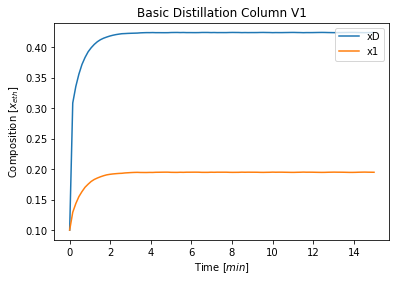

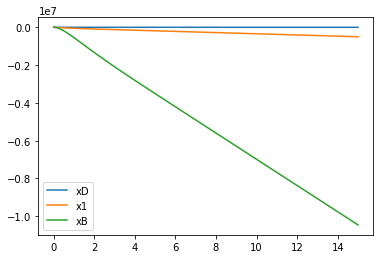

In [242]:
plt.figure(1)
plt.title("Basic Distillation Column V1")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
# plt.plot(t,x2, label = "xB")
plt.xlabel("Time [$min$]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")
# plt.savefig("Basic_distillation_column_V1.svg")

plt.figure(2)
plt.plot(t,h0, label = "xD")
plt.plot(t,h1, label = "x1")
plt.plot(t,h2, label = "xB")
plt.legend()
print(x0[-1], x1[-1],x2[-1])
# 0.4221781484681993 0.07790814682274913 rr 10
# 0.40610461779466533 0.09398329954517895 rr 0.6

In [ ]:
init = [0.1, 0.1, 0.1,0]

F = 1 # Feed on plate 3
D = 0.5
xF = 0.5 # mole fraction in feed
R_r = 0.6 # reflux ratio

m_cond = 0.15 # holdup in condenser
m_tray = 0.2 # holdup on each tray
m_rebl = 0.45 # holdup in reboiler
mt = 0.15+0.2+0.45

tspan = (0, 15)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mod, tspan, init, t_eval=t)

x0,x1,x2,B = initial_run.y

plt.figure(1)
plt.title("Basic Distillation Column V1")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "xB")
# plt.plot(t,xt, label = "xt")
plt.xlabel("Time [$min$]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")
print(x0[-1],x2[-1])

# 0.5834075415038531 0.12830397916296193
# 0.5915477977815078 0.11334777740140549
# 0.5934497927845376 0.10998832135621528

# Consistency plot of model

The idea to assume CMO and constant hold up creates a scenario where mass is "created" to fulfill both the criterias. The plot below will show that there accumulation occuring in the column increases yet the mass balance decreases to zero. These two are thus contradictory because the mass balance should produce the exact same accumulation.

The mass balance is calculated as follows:

$M_{t}\frac{dx_t}{dt} = x_FF -x_BB - x_DD$

And the accumulation is calculated as follows:

$M_{t}\frac{dx_t}{dt} = \sum{M_i\frac{dx_i}{dt}}$

where 
- $M_t$ is the total mass accumulated in the column
- $x_t$ is the mole fraction of the mass in the column
- $M_i$ is the total mass accumulated on each tray $i$.

In [ ]:
L1 = R_r*D
V = L1 + D
L2 = F3 + L1
L3 = F7 + L2

moles_inside_column_at_zero = (x0s[0]*m_cond+x1s[0]*m_tray+x2s[0]*m_tray+x3s[0]*m_tray+x4s[0]*m_tray+x5s[0]*m_tray+x6s[0]*m_tray+
                       x7s[0]*m_tray+x8s[0]*m_tray+x9s[0]*m_tray+x10s[0]*m_tray+x11s[0]*m_rebl)

# This calculated the accumulation insie the column through summing the accumulation on each plate
moles_inside_column = (x0s*m_cond+x1s*m_tray+x2s*m_tray+x3s*m_tray+x4s*m_tray+x5s*m_tray+x6s*m_tray+
                       x7s*m_tray+x8s*m_tray+x9s*m_tray+x10s*m_tray+x11s*m_rebl) - moles_inside_column_at_zero


integral = []
for i in range(1,len(t)+1):
    dMtxtdt = xF*F3 - (D)*(x0s[0:i])- (L3-V)*x11s[0:i]
    integral.append(np.trapz(dMtxtdt,t[0:i]))

plt.figure(1)
plt.subplot(2,1,1)
plt.title("Consistency Plot")
plt.xlabel("Time")
plt.ylabel("Accumulation of mass")
plt.plot(t,integral, label = "Mole balance")
plt.plot(t,moles_inside_column, label = "Diff equations")
# plt.ylim(0,0.3)
plt.legend(loc="best")
plt.subplot(2,1,2)
plt.plot(t,abs(moles_inside_column-integral), label = "Error")
# plt.ylim(0,0.0003)
plt.xlabel("Time [$min$]")
plt.ylabel("Absolute error")
plt.savefig("consistency_plot_error_V1.svg")

## Reflux ratio step

The reflux ratio is stepped with a factor of 2.

In [ ]:
tspan = (0, 10)
t = np.linspace( *tspan, 10000)
R_r = 0.8*3 
reflux_step = scipy.integrate.solve_ivp(mod, tspan, xi, t_eval=t)
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = reflux_step.y

In [ ]:
xi = [x0[-1],x1[-1],x2[-1],x3[-1],x4[-1],x5[-1],x6[-1],x7[-1],x8[-1],x9[-1],x10[-1],x11[-1]]

In [ ]:
plt.figure(2)
plt.title("Reflux step test")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")
plt.savefig('Feed_step2.svg')

## Feed flow rate step

The feed rate on plate 3 is stepped with a factor of 20.

In [ ]:
tspan = (0, 10)
t = np.linspace( *tspan, 10000)
R_r = 0.8
F3 = F3*3
feed_step = scipy.integrate.solve_ivp(mod, tspan, xi, t_eval=t)
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = feed_step.y

In [ ]:
plt.figure(3)
plt.title("Feed flow rate step")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")
plt.savefig('Feed_step2.svg')

## Feed compositon step

The feed on plate 3 is stepped by a factor of 2.

In [ ]:
tspan = (0, 10)
t = np.linspace( *tspan, 100)
F3 = 1
xF = xF*2
composition_step = scipy.integrate.solve_ivp(mod, tspan, xi, t_eval=t)
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = composition_step.y

In [ ]:
plt.figure('twxt')
plt.title("Feed composition step")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")

## Distillate to feed ratio step

The distillate to feed ratio is stepped by a factor of 2.

In [ ]:
tspan = (0, 10)
t = np.linspace( *tspan, 100)
xF = 0.25
D = D*1.1
d_f_ratio_step = scipy.integrate.solve_ivp(mod, tspan, xi, t_eval=t)
x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = d_f_ratio_step.y

In [ ]:
plt.figure('Distillate_feed_step')
plt.title("Distillate to feed ratio step")
plt.plot(t,x0, label = "xD")
plt.plot(t,x1, label = "x1")
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.plot(t,x4, label = "x4")
plt.plot(t,x5, label = "x5")
plt.plot(t,x6, label = "x6")
plt.plot(t,x7, label = "x7")
plt.plot(t,x8, label = "x8")
plt.plot(t,x9, label = "x9")
plt.plot(t,x10, label = "x10")
plt.plot(t,x11, label = "xB")
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")